In [1]:
#! pip install Geopandas
#!pip install --use-deprecated=legacy-resolver pycaret[full]
#!pip install pycaret[full]

In [46]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats


# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D


import sklearn
from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

from pycaret.datasets import get_data
from pycaret.regression import *

from scipy.signal import medfilt2d

In [3]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'xls'

In [4]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dcombined.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,source_id,source_lat,source_lon,source_type_y,ipcc,number_overflights,source_persistence,confidence_in_persistence,qsource,sigma_qsource,Filepath,Name,candidate_id,plume_lat,plume_lon,date,qplume,sigma_qplume,Uncern
0,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217-plume.png,ang20190922t192642-2,32.212063,-103.697076,2019-09-22,2579.528100,902.732655,34.996039
1,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190923t163307-G_r4113_c198-plume.png,ang20190923t163307-G,32.212117,-103.697086,2019-09-23,934.430300,276.716131,29.613352
2,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190926t223557-D_r4139_c225-plume.png,ang20190926t223557-D,32.212162,-103.696830,2019-09-26,443.098484,152.257940,34.362099
3,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191006t150453-6_r4168_c237-plume.png,ang20191006t150453-6,32.212327,-103.697526,2019-10-06,1032.395030,606.623335,58.758839
4,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191007t182352-2_r4062_c150-plume.png,ang20191007t182352-2,32.212253,-103.697253,2019-10-07,826.823256,226.851094,27.436468


In [5]:
df.shape

(6062, 19)

In [6]:
def image_processing(fil):
#Open image and import it as a numpy array
    im2 = imread(fil)
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,mask2.shape[0]):
        for j in range(0,mask2.shape[1]):
            feature_matrix[i][j] = ((int(mask2[i,j,0]) + int(mask2[i,j,1]) + int(mask2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [7]:
#pic_list = []
#name_list = []
#qplume = []
image_list = []

In [8]:
for file in tqdm(df['Filepath'].tolist()[:]):
    image_list.append(image_processing(file))

100%|██████████| 6062/6062 [06:09<00:00, 16.40it/s]


In [9]:
X = np.array(image_list)

In [10]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [43.33333333,  0.        ,  0.        , ..., 34.66666667,
        31.66666667, 29.66666667],
       [ 0.        ,  0.        ,  0.        , ..., 45.66666667,
         0.        ,  0.        ],
       [42.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [11]:
np.save('processed_128x128_image.npy',X,allow_pickle=True)

In [12]:
X.mean()

6.816430636294849

In [13]:
X.shape

(6062, 47089)

In [14]:
Y = np.array(df.qplume.tolist())

In [15]:
Y

array([2579.5281   ,  934.4303004,  443.0984843, ...,  438.4123065,
        674.2734901,  475.3739425])

In [16]:
print(X.shape)
print(Y.shape)

(6062, 47089)
(6062,)


In [17]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [18]:
img_rows, img_cols = 217, 217
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(1213, 217, 217, 1)

In [19]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [20]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(3636, 217, 217, 1)
(3636,)
(1213, 217, 217, 1)
(1213,)
(1213, 217, 217, 1)
(1213,)


In [47]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))

learning_rate = 0.0001

model.compile(loss='mse',
              optimizer=Adam(learning_rate))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 217, 217, 16)      160       
                                                                 
 batch_normalization_6 (Batc  (None, 217, 217, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 217, 217, 16)      2320      
                                                                 
 batch_normalization_7 (Batc  (None, 217, 217, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 108, 108, 16)     0         
 2D)                                                             
                                                      

In [48]:
save_at = "model_regression2.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [49]:
np.isnan(X).any()

False

In [50]:
np.isnan(Y).any()

False

In [51]:
#Train the CNN
history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_val))

Epoch 1/15
37/37 [==============================] - 187s 5s/step - loss: 1018727.9375 - val_loss: 659229.9375
Epoch 2/15
37/37 [==============================] - 175s 5s/step - loss: 991824.2500 - val_loss: 652383.1250
Epoch 3/15
37/37 [==============================] - 171s 5s/step - loss: 935691.5000 - val_loss: 644950.3750
Epoch 4/15
37/37 [==============================] - 178s 5s/step - loss: 844766.5000 - val_loss: 635004.7500
Epoch 5/15
37/37 [==============================] - 171s 5s/step - loss: 734024.4375 - val_loss: 616041.6250
Epoch 6/15
37/37 [==============================] - 171s 5s/step - loss: 645274.6250 - val_loss: 588165.9375
Epoch 7/15
37/37 [==============================] - 180s 5s/step - loss: 600326.6875 - val_loss: 565896.4375
Epoch 8/15
37/37 [==============================] - 172s 5s/step - loss: 579788.6250 - val_loss: 533027.3750
Epoch 9/15
37/37 [==============================] - 173s 5s/step - loss: 569633.5625 - val_loss: 514846.4375
Epoch 10/15
37/37 

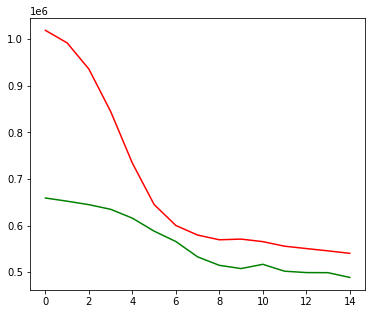

In [52]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [53]:
Y_pred = np.round(model.predict(X_test))

38/38 [==============================] - 9s 245ms/step


In [54]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 880.5161794997805
Test R^2 Score: -0.15154


In [29]:
image_sub = []

In [30]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [31]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [32]:
df_testpaths = testpaths.to_frame()

In [33]:
res = os.listdir(image_test)
df_testpaths['Name'] = pd.DataFrame (res, columns = ['TestName'])

In [34]:
def image_processingsub(fil):
#Open image and import it as a numpy array
    
    
    im2 = imread(fil)
    im2 = cv2.resize(im2, (217, 217))
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,mask2.shape[0]):
        for j in range(0,mask2.shape[1]):
            feature_matrix[i][j] = ((int(mask2[i,j,0]) + int(mask2[i,j,1]) + int(mask2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [35]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    image_sub.append(image_processingsub(file))

100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


In [36]:
X_sub = np.array(image_sub)

In [37]:
X_sub.shape

(20, 47089)

In [38]:
np.save('sub_image.npy',X_sub,allow_pickle=True)

In [39]:
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)

In [40]:
Y_sub = np.round(model.predict(X_sub))

1/1 [==============================] - 0s 153ms/step


In [41]:
Y_sub

array([[609.],
       [897.],
       [226.],
       [154.],
       [609.],
       [328.],
       [630.],
       [305.],
       [423.],
       [308.],
       [458.],
       [793.],
       [180.],
       [299.],
       [659.],
       [477.],
       [605.],
       [466.],
       [276.],
       [335.]], dtype=float32)

In [42]:
np.savetxt('16h.csv', Y_sub, delimiter=',')